## Development space for CoinciERAvie:

for those wondering: its a mix of the words coincidence - ERA5 and a joke on the Micheal Cera CeraVe ad



In [1]:
import xarray as xr
path = "/gws/nopw/j04/global_ex/data/"
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

d_daily = xr.open_zarr(
    path + "era5.zarr",
    chunks={}, 
    consolidated=True, use_cftime=True
)
d_daily = d_daily.rename({"latitude": "lat", "longitude": "lon"})

/tmp/ipykernel_3730713/705882391.py:8: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  d_daily = xr.open_zarr(


---
### Section 1: figuring out how to do a running window extreme temp thing

- This code looks at a wholistic basis (not breaking things up month by month or season by season)
- runs a 5 year centered window
- within window it compute quantiles as thresholds
- then within the window finds the mean of days exceeding said threshold for each quantile of temperature

**Next Steps**
- be able to compute other values for these extreme days


In [206]:
# ------------------------------------------------------------
# using the 21-year centered exceedance thingy
# ------------------------------------------------------------

import numpy as np
import xarray as xr

qvals = [0.5, 0.95]   # median + extreme
nyears = 21

# Select latitude band
T = d_daily.t2m.sel(lat=slice(20, -20))
CAPE = d_daily.cape.sel(lat=slice(20, -20))

# Add year coordinate
T = T.assign_coords(year=T["time.year"])
CAPE = CAPE.assign_coords(year=CAPE["time.year"])

years = np.unique(T.year.values)

T_q_list = []
T_exceed_list = []
T_mean_list = []
year_center = []

half = nyears // 2

for y0 in years:
    y_start = y0 - half
    y_end   = y0 + half

    if (y_start < years.min()) or (y_end > years.max()):
        continue  # skip incomplete blocks

    # 21-year block
    T_blk = T.where((T.year >= y_start) & (T.year <= y_end), drop=True)
    # Quantiles over block
    T_q = T_blk.quantile(qvals, dim="time")
    # dims: (quantile, lat)
    T_blk_mean = T_blk.mean("time")

    # Exceedance relative to 95th percentile
    mask_95 = T_blk > T_q.sel(quantile=0.95)

    # Mean temperature on extreme days
    T_95 = T_blk.where(mask_95).mean("time")

    T_q_list.append(T_q)
    T_exceed_list.append(T_95)
    year_center.append(y0)
    T_mean_list.append(T_blk_mean)

# Stack results
T_q = xr.concat(T_q_list, dim="year").assign_coords(year=year_center)
T_95 = xr.concat(T_exceed_list, dim="year").assign_coords(year=year_center)
T_mean = xr.concat(T_mean_list, dim="year").assign_coords(year=year_center)

# Save DataArrays for later use - this can take a while
T_q.to_netcdf("Scratch/T_q.nc")
T_95.to_netcdf("Scratch/T_95.nc")
T_mean.to_netcdf("Scratch/T_mean.nc")

In [2]:

T_q = xr.open_dataset('Scratch/T_q.nc').load()
T_95 = xr.open_dataset('Scratch/T_95.nc').load()
T_mean = xr.open_dataset('Scratch/T_mean.nc').load()
print("Data loaded.")

# ------------------------------------------------------------
def ai_label(ai):   # Based of Simpson et al. 2024 classification
    if ai < 0.05: return 'HyperArid'
    elif ai <= 0.5: return 'AridSemiArid'
    elif np.isnan(ai): return 'None'
    else: return 'Humid'

ds_AI = xr.open_dataset('/home/users/chingosa/TropExt/CMIP6_Analysis/Terra_AI_values.nc')
ds_AI_interp = ds_AI.interp(lat=d_daily.lat, lon=d_daily.lon, method='linear')
ds_AI_interp['AI_class'] = xr.apply_ufunc(ai_label, ds_AI_interp.AI.compute(), vectorize=True)
# ------------------------------------------------------------
weights = np.cos(np.deg2rad(T_q.lat))
weights = weights / weights.mean()
# ------------------------------------------------------------
years = np.unique(d_daily.time.dt.year.values)
year_center = []
nyears = 21
half = nyears // 2
for y0 in years:
    y_start = y0 - half
    y_end   = y0 + half
    if (y_start < years.min()) or (y_end > years.max()):
        continue  # skip incomplete blocks
    year_center.append(y0)

lsm = d_daily.lsm.sel(lat = slice(20, -20)).isel(time=0) > 0.5
baseline = year_center[0]  # first year with complete 21-year block - centered on 1989
# ------------------------------------------------------------

saveData_median = []
saveData_mean = []
for region in ['AridSemiArid', 'Humid', 'HyperArid', 'All']:
    if region == 'All': regionMask = xr.full_like(ds_AI_interp['AI_class'], True, dtype=bool)
    else:               regionMask = (ds_AI_interp['AI_class'] == region)

    # compute the T_95 anomaly relative to baseline and change in median/ mean temperature
    T_95_anom = (T_95.where(lsm & regionMask).weighted(weights).mean(("lat", "lon")).sel(year=slice(baseline+1, None)) - 
                  T_95.where(lsm & regionMask).weighted(weights).mean(("lat", "lon")).sel(year=baseline))
    T_med_anom = (T_q.sel(quantile=0.5).where(lsm & regionMask).weighted(weights).mean(("lat", "lon")).sel(year=slice(baseline+1, None)) - 
                   T_q.sel(quantile=0.5).where(lsm & regionMask).weighted(weights).mean(("lat", "lon")).sel(year=baseline))
    T_mean_anom = (T_mean.where(lsm & regionMask).weighted(weights).mean(("lat", "lon")).sel(year=slice(baseline+1, None)) - 
                    T_mean.where(lsm & regionMask).weighted(weights).mean(("lat", "lon")).sel(year=baseline))

    # --------Ratio of extreme warming to median warming----------
    amp_ratio_median = T_95_anom.t2m / T_med_anom.t2m
    amp_ratio_median.name = r"$\delta T_L^{95} / \delta T_{\text{med}}$"
    saveData_median.append(amp_ratio_median.assign_coords(region=region))

    amp_ratio_mean = T_95_anom.t2m / T_mean_anom.t2m
    amp_ratio_mean.name = r"$\delta T_L^{95} / \delta T_{\text{mean}}$"
    saveData_mean.append(amp_ratio_mean.assign_coords(region=region))


ds_median = xr.concat(saveData_median, dim="region")
ds_mean = xr.concat(saveData_mean, dim="region")

Data loaded.


len AI_All before NaN removal: 231840
len AI_All: 54117
HyperArid portion: 6.48%
AridSemiArid portion: 19.72%
Humid portion: 73.80%


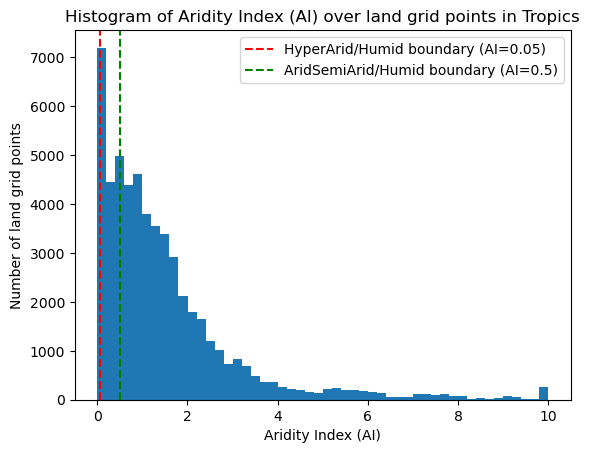

In [17]:
AI_All = ds_AI_interp['AI'].where(lsm).values.flatten()
print('len AI_All before NaN removal:', len(AI_All), )
AI_All = AI_All[~np.isnan(AI_All)]

print('len AI_All:', len(AI_All), )
plt.hist(AI_All, bins=50)
## Adding portion of area in each AI category
n_total = len(AI_All)
n_hyperarid = np.sum(AI_All < 0.05)
n_aridsemarid = np.sum((AI_All >= 0.05) & (AI_All <= 0.5))
n_humid = np.sum(AI_All > 0.5)
print(f'HyperArid portion: {n_hyperarid/n_total:.2%}')
print(f'AridSemiArid portion: {n_aridsemarid/n_total:.2%}')
print(f'Humid portion: {n_humid/n_total:.2%}')
plt.axvline(x=0.05, color='r', linestyle='--', label='HyperArid/Humid boundary (AI=0.05)')
plt.axvline(x=0.5, color='g', linestyle='--', label='AridSemiArid/Humid boundary (AI=0.5)')
plt.xlabel('Aridity Index (AI)')
plt.ylabel('Number of land grid points')
plt.title('Histogram of Aridity Index (AI) over land grid points in Tropics')
plt.legend()
plt.show()

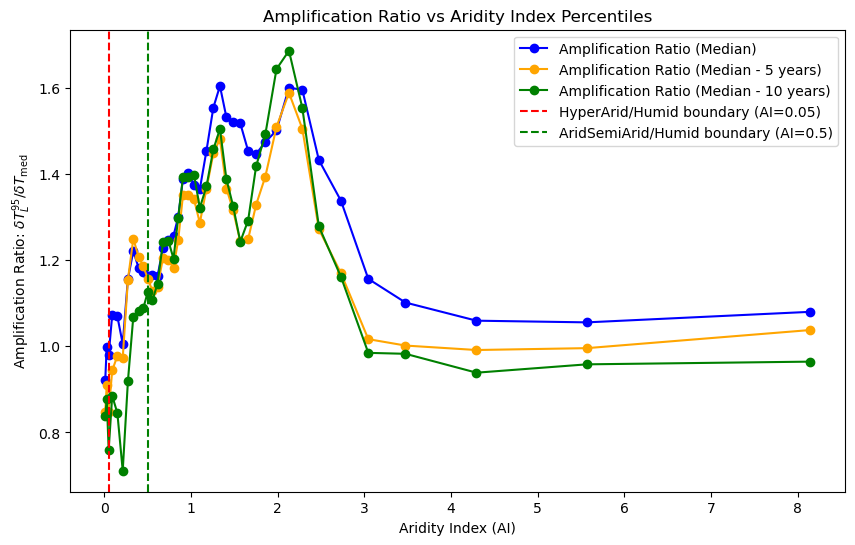

In [46]:
## Ploting the amplification ratios as a function of aridity index broken into percentiles of AI index:
AI_All = ds_AI_interp['AI'].where(lsm)
AI_All_vals = AI_All.values.flatten()
AI_All_vals = AI_All_vals[~np.isnan(AI_All_vals)]

percentiles = np.percentile(AI_All_vals, np.arange(0, 101, 2.5))  # 0th to 100th percentile in steps of 2.5%
ai_bins = percentiles
ai_bin_centers = (ai_bins[:-1] + ai_bins[1:]) / 2

fig, ax = plt.subplots(figsize=(10, 6))

bin_means_yrlast = []
bin_means_yrlast_1 = []
bin_means_yrlast_2 = []


for i in range(len(ai_bins) - 1):

    bin_mask = (AI_All >= ai_bins[i]) & (AI_All < ai_bins[i + 1])
    
    T_95_anom = (T_95.where(lsm & bin_mask).weighted(weights).mean(("lat", "lon")).sel(year=slice(baseline+1, None)) - 
                  T_95.where(lsm & bin_mask).weighted(weights).mean(("lat", "lon")).sel(year=baseline))
    T_med_anom = (T_q.sel(quantile=0.5).where(lsm & bin_mask).weighted(weights).mean(("lat", "lon")).sel(year=slice(baseline+1, None)) - 
                   T_q.sel(quantile=0.5).where(lsm & bin_mask).weighted(weights).mean(("lat", "lon")).sel(year=baseline))
    amp_ratio_median = T_95_anom.t2m / T_med_anom.t2m

    
    if np.sum(bin_mask) > 0:
        bin_mean = amp_ratio_median.isel(year = -1).values.item()
        bin_mean_1 = amp_ratio_median.isel(year = -5).values.item()
        bin_mean_2 = amp_ratio_median.isel(year = -10).values.item()
    else:
        bin_mean = np.nan
        bin_mean_1 = np.nan
        bin_mean_2 = np.nan
    bin_means_yrlast.append(bin_mean)
    bin_means_yrlast_1.append(bin_mean_1)
    bin_means_yrlast_2.append(bin_mean_2)

ax.plot(ai_bin_centers, bin_means_yrlast, marker='o', label='Amplification Ratio (Median)', color='b')
ax.plot(ai_bin_centers, bin_means_yrlast_1, marker='o', label='Amplification Ratio (Median - 5 years)', color='orange')
ax.plot(ai_bin_centers, bin_means_yrlast_2, marker='o', label='Amplification Ratio (Median - 10 years)', color='green')

ax.set_xlabel('Aridity Index (AI)')
ax.set_ylabel(r'Amplification Ratio: $\delta T_L^{95} / \delta T_{\mathrm{med}}$')
ax.set_title('Amplification Ratio vs Aridity Index Percentiles')
plt.axvline(x=0.05, color='r', linestyle='--', label='HyperArid/Humid boundary (AI=0.05)')
plt.axvline(x=0.5, color='g', linestyle='--', label='AridSemiArid/Humid boundary (AI=0.5)')
plt.axhline(y =1, color='k', linestyle=':', label='No Amplification Line')
ax.legend()
plt.show()

In [44]:
ai_bin_centers

array([0.01826023, 0.07635831, 0.17900661, 0.30283694, 0.41967463,
       0.5291119 , 0.64667418, 0.76795023, 0.88108996, 1.00115926,
       1.14305531, 1.29563991, 1.44850894, 1.61570171, 1.81205469,
       2.06206261, 2.39660013, 2.90293874, 4.03797497, 7.42858255])

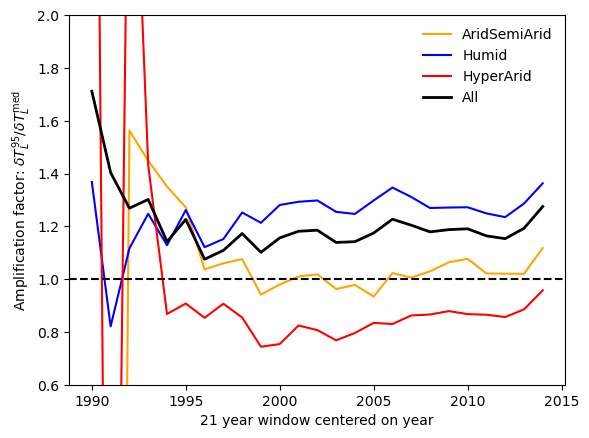

In [10]:
## this is showing that over this historical period - amplification of extremes compared to the mean temp change emerges
## however this is mostly due to a large portion of area being humid regions with amplification near 1.3 while arid regions show a lower amplification factor...

for region, c, lw in zip(ds_median.region.values, ['orange', 'blue', 'red', 'k'], [1.5,1.5,1.5,2]):
    plt.plot(ds_median.sel(region=region).year, ds_median.sel(region=region), label=region, color=c, linewidth=lw)

plt.ylim(0.6, 2)

plt.axhline(1.0, color='k', linestyle='--')
plt.legend(frameon=False)
plt.xlabel("21 year window centered on year")
plt.ylabel(r"Amplification factor: $\delta T_L^{95} / \delta T^{\mathrm{med}}_L$")
plt.show()


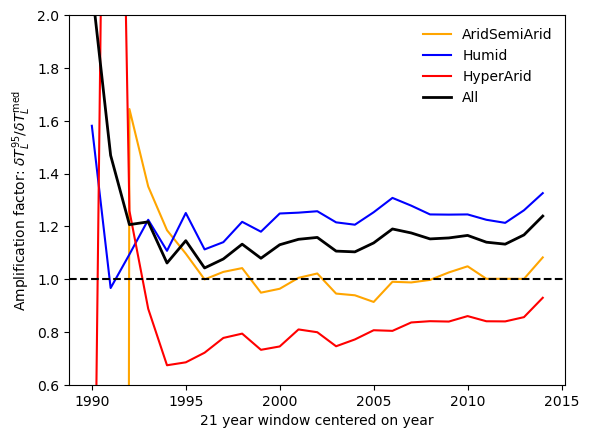

In [11]:
## this is showing that over this historical period - amplification of extremes compared to the mean temp change emerges
## however this is mostly due to a large portion of area being humid regions with amplification near 1.3 while arid regions show a lower amplification factor...

for region, c, lw in zip(ds_mean.region.values, ['orange', 'blue', 'red', 'k'], [1.5,1.5,1.5,2]):
    plt.plot(ds_mean.sel(region=region).year, ds_mean.sel(region=region), label=region, color=c, linewidth=lw)

plt.ylim(0.6, 2)
plt.axhline(1.0, color='k', linestyle='--')
plt.legend(frameon=False)
plt.xlabel("21 year window centered on year")
plt.ylabel(r"Amplification factor: $\delta T_L^{95} / \delta T^{\mathrm{med}}_L$")
plt.show()


In [13]:

lsm = d_daily.lsm.sel(lat = slice(20, -20)).isel(time=0)

print("Area-averaging complete.")
# ------------------------------------------------------------
# Compute changes relative to a baseline period
# ------------------------------------------------------------
baseline = year_center[0]  # 21 yrs

T_95_anom  = T_95 - T_95.sel(year=baseline)
T_med_anom = T_q.sel(quantile=0.5) - T_q.sel(quantile=0.5).sel(year=baseline)
# ------------------------------------------------------------
# 1) Ratio of extreme warming to median warming
amp_ratio = T_95_anom.t2m / T_med_anom.t2m
amp_ratio.name = "Extreme-to-median amplification"


Area-averaging complete.


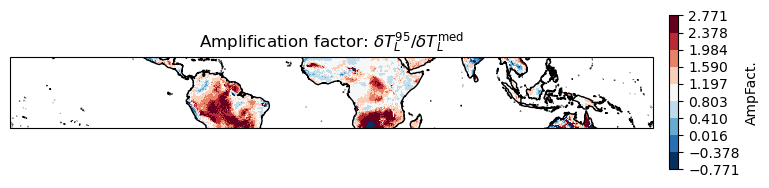

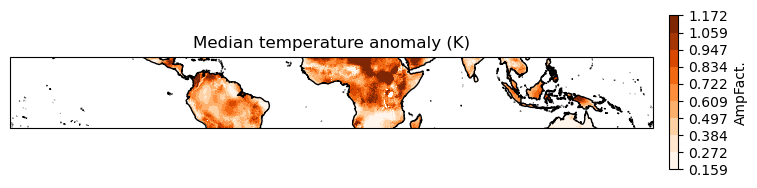

In [ ]:


def plot_amp_map(
    vals,
    year,
    center=0,
    qmin=0.05,
    qmax=0.95,
    cmap="RdBu_r",
    nlevels=11,
    figsize=(10, 5),
    projection=ccrs.PlateCarree(),
    symmetric=True,
    title=""
):
    """
    Robust amplification map with discrete color levels.
    Limits are computed from the plotted year only.
    """

    field = vals.sel(year=year)

    # --- robust limits (THIS year only) ---
    lo = np.nanpercentile(field, qmin * 100)
    hi = np.nanpercentile(field, qmax * 100)

    if symmetric:
        span = max(abs(hi - center), abs(lo - center))
        vmin, vmax = center - span, center + span
    else:
        vmin, vmax = lo, hi

    # --- discrete levels ---
    levels = np.linspace(vmin, vmax, nlevels + 1)

    # split levels around center
    left_levels  = levels[levels < center]
    right_levels = levels[levels > center]
    
    norm = BoundaryNorm(levels, ncolors=plt.get_cmap(cmap).N, clip=True)

    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={"projection": projection}
    )

    pcm = ax.pcolormesh(
        vals.lon,
        vals.lat,
        field,
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
    )

    cbar = fig.colorbar(
        pcm,
        ax=ax,
        pad=0.02,
        aspect=16,
        shrink=0.4,
        ticks=levels[:],  # fewer ticks = cleaner
    )

    cbar.set_label('AmpFact.')

    ax.coastlines()
    ax.set_title(title)

    return fig, ax
fig, ax = plot_amp_map(
    amp_ratio.where(lsm > 0.5),
    year=year_center[-1],
    center=1.0,
    cmap="RdBu_r",
    nlevels=9,
    title = r"Amplification factor: $\delta T_L^{95} / \delta T^{\mathrm{med}}_L$"
)
fig, ax = plot_amp_map(
    T_med_anom.t2m.where(lsm > 0.5), 
    year=year_center[-1],
    center=110,
    symmetric=False,
    cmap="Oranges",
    nlevels=9,
    title = r"Median temperature anomaly (K)"
)

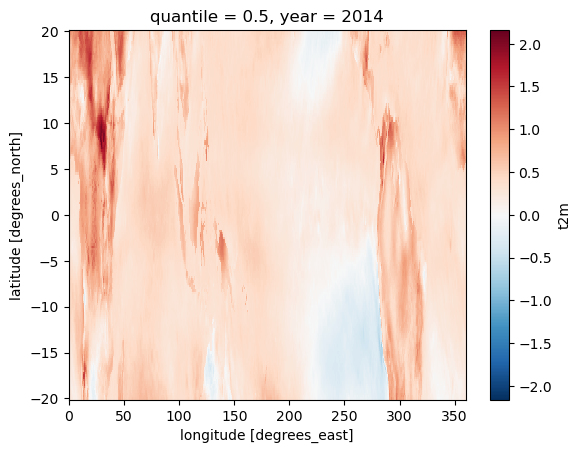

In [17]:
T_med_anom.isel(year = -1).t2m.plot()

/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


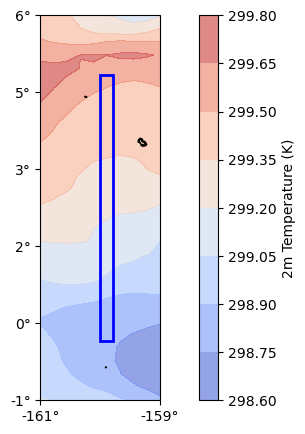

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# ---- SELECTION ----
lat_sel = slice(340, 360)   # example
lon_sel = 800               # could be slice or int
pad = 5                    # crop area padding, does NOT affect rectangle
# --------------------

# Extract selected lat values
lat_vals = d_daily.lat.isel(lat=lat_sel).values
lat_min = lat_vals.min()
lat_max = lat_vals.max()

# Extract selected lon values (index OR slice)
lon_vals = d_daily.lon.isel(lon=lon_sel).values
lon_vals = np.atleast_1d(lon_vals)

# Convert lon to [-180,180]
lon_vals_plot = ((lon_vals + 180) % 360) - 180
lon_min = lon_vals_plot.min()
lon_max = lon_vals_plot.max()

# ---- OPTIONAL: crop around the region (±pad grid cells) ----
# Works with lon_sel = int or slice
if isinstance(lon_sel, int):
    lon0 = lon_sel - pad
    lon1 = lon_sel + pad
else:
    lon0 = lon_sel.start - pad
    lon1 = lon_sel.stop  + pad

lat0 = lat_sel.start - pad
lat1 = lat_sel.stop  + pad

ds_crop = d_daily.isel(
    lat=slice(max(lat0, 0), min(lat1, len(d_daily.lat))),
    lon=slice(max(lon0, 0), min(lon1, len(d_daily.lon)))
)

# Cropped grid for plotting
lon_plot = ((ds_crop.lon.values + 180) % 360) - 180
lat_plot = ds_crop.lat.values

# ---- PLOT ----
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# background field adding cbar
plt.contourf(
    lon_plot, lat_plot, ds_crop.t2m.isel(time=0),
    transform=ccrs.PlateCarree(),
    shading="auto", cmap="coolwarm", alpha=0.6
)
plt.colorbar(label="2m Temperature (K)") 
# ---- RECTANGLE AROUND EXACT GRID CELLS ----
# Rectangle covers EXACT lon_min → lon_max and lat_min → lat_max from selection adding half a grid box to each side
lon_res = np.abs(d_daily.lon[1] - d_daily.lon[0]).values
lat_res = np.abs(d_daily.lat[1] - d_daily.lat[0]).values
rect = plt.Rectangle(
    (lon_min - lon_res/2, lat_min - lat_res/2),
    lon_max - lon_min + lon_res,
    lat_max - lat_min + lat_res,
    linewidth=2,
    edgecolor='blue',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(rect)

# Crop the plot to the padded region
ax.set_extent(
    [
        lon_plot.min(), lon_plot.max(),
        lat_plot.min(), lat_plot.max()
    ],
    crs=ccrs.PlateCarree()
)
# choose ~5 ticks per axis
xmin, xmax, ymin, ymax = ax.get_extent(ccrs.PlateCarree())

xticks = np.linspace(xmin, xmax, 2)   # 6 → 5 intervals
yticks = np.linspace(ymin, ymax, 6)

ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

# optional: format as degrees with cardinal letters
ax.xaxis.set_major_formatter(plt.FuncFormatter(
    lambda x, _: f"{x:.0f}°"
))
ax.yaxis.set_major_formatter(plt.FuncFormatter(
    lambda y, _: f"{y:.0f}°"
))
plt.show()

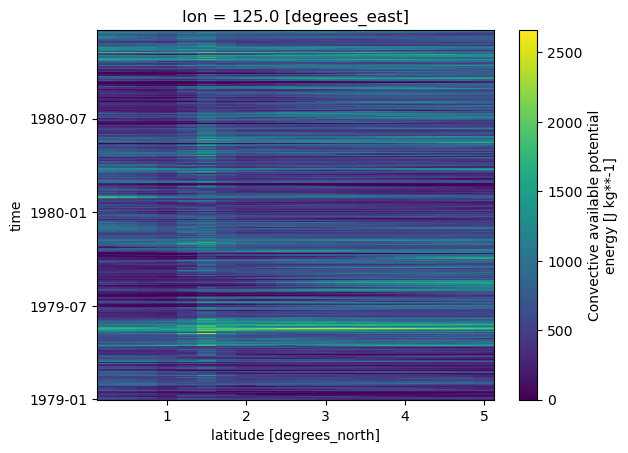

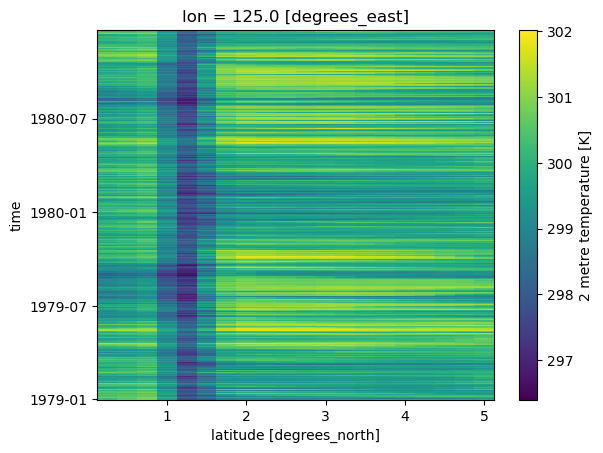

In [50]:
import matplotlib.pyplot as plt
CAPE.isel(time=slice(0, 720)).plot()
plt.show()
T.isel(time=slice(0, 720)).plot()

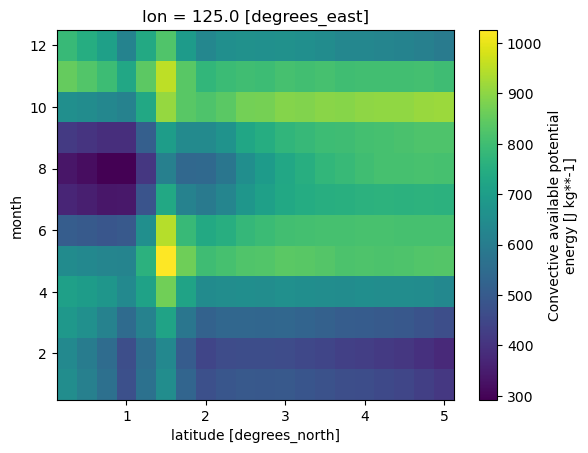

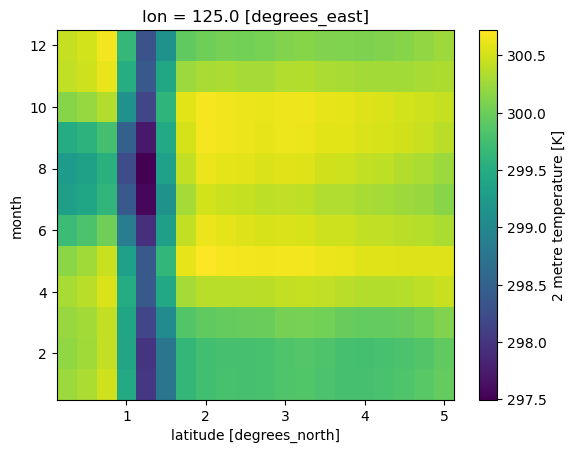

In [51]:
import matplotlib.pyplot as plt
CAPE.groupby("time.month").mean("time").plot()
plt.show()
T.groupby("time.month").mean("time").plot()

---
### Section 2: JHM - joint histogram maker


In [131]:
reqDims = ['time', 'lat', 'lon']
ignoreDims = ['level']

analysis_vars = []
for var in d_daily.variables:

    if d_daily[var].dims == tuple(reqDims):
        print(f"{var} has required dims {reqDims}")
        analysis_vars.append(var)
    elif any(dim in d_daily[var].dims for dim in ignoreDims):
        print(f"{var} has ignored dims {ignoreDims}")
    else:
        print(f"{var} does not have required dims {reqDims}")

blh has required dims ['time', 'lat', 'lon']
cape has required dims ['time', 'lat', 'lon']
cc has ignored dims ['level']
cin has required dims ['time', 'lat', 'lon']
ciwc has ignored dims ['level']
clwc has ignored dims ['level']
d2m has required dims ['time', 'lat', 'lon']
hcc has required dims ['time', 'lat', 'lon']
ie has required dims ['time', 'lat', 'lon']
lcc has required dims ['time', 'lat', 'lon']
lsm has required dims ['time', 'lat', 'lon']
lsrr has required dims ['time', 'lat', 'lon']
mcc has required dims ['time', 'lat', 'lon']
mcpr has required dims ['time', 'lat', 'lon']
mer has required dims ['time', 'lat', 'lon']
mlspr has required dims ['time', 'lat', 'lon']
mper has required dims ['time', 'lat', 'lon']
mror has required dims ['time', 'lat', 'lon']
mslhf has required dims ['time', 'lat', 'lon']
msnlwrf has required dims ['time', 'lat', 'lon']
msnlwrfcs has required dims ['time', 'lat', 'lon']
msnswrf has required dims ['time', 'lat', 'lon']
msnswrfcs has required dims [

Processing variable: blh


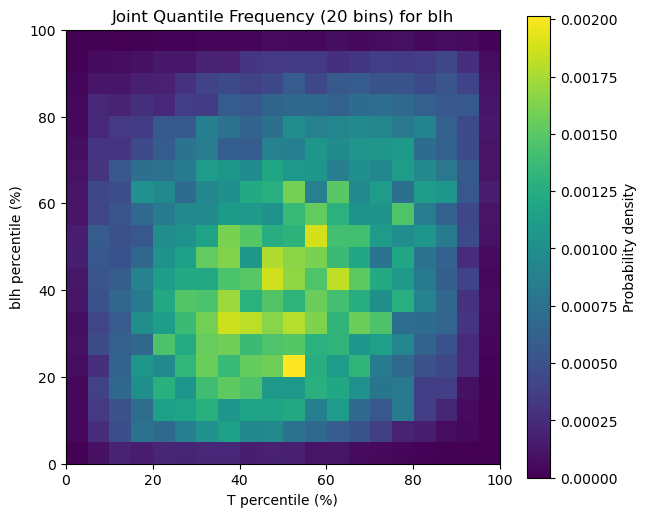

Processing variable: cape


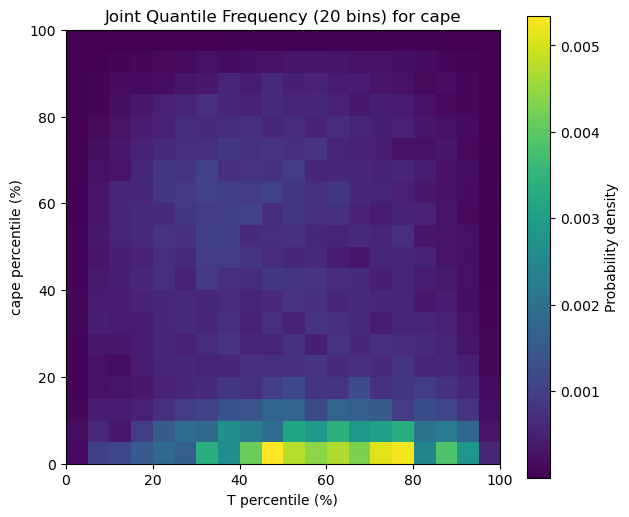

Processing variable: cin


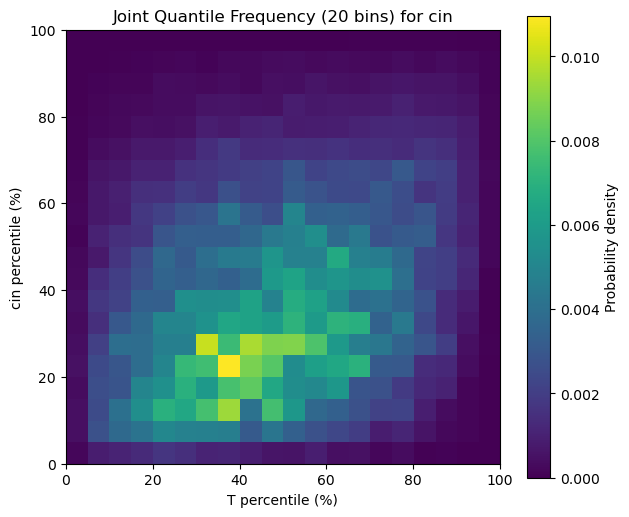

Processing variable: d2m


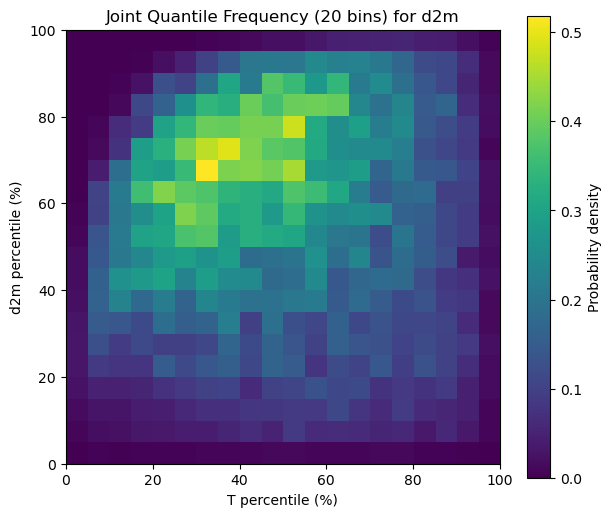

Processing variable: hcc
Not enough data points for variable hcc, skipping.
Processing variable: ie
Not enough data points for variable ie, skipping.
Processing variable: lcc
Not enough data points for variable lcc, skipping.
Processing variable: lsm


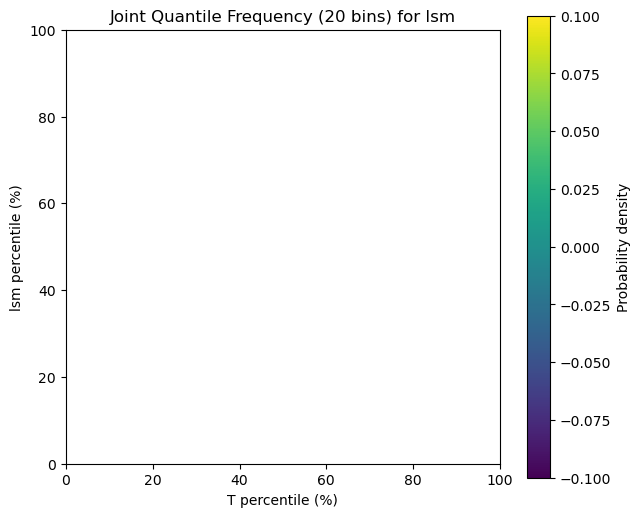

Processing variable: lsrr
Not enough data points for variable lsrr, skipping.
Processing variable: mcc
Not enough data points for variable mcc, skipping.
Processing variable: mcpr


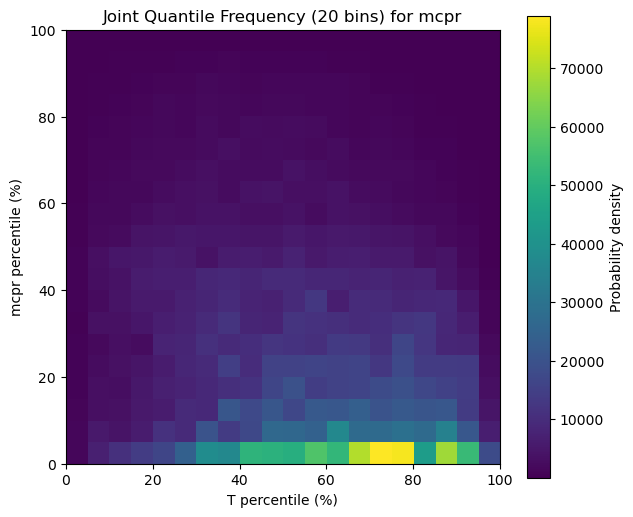

Processing variable: mer


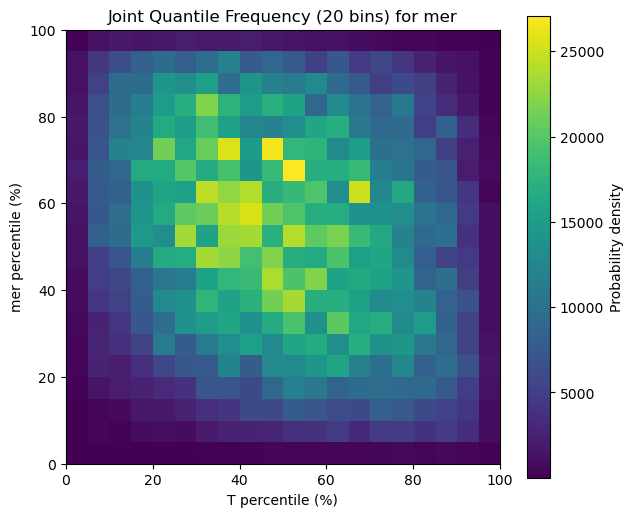

Processing variable: mlspr


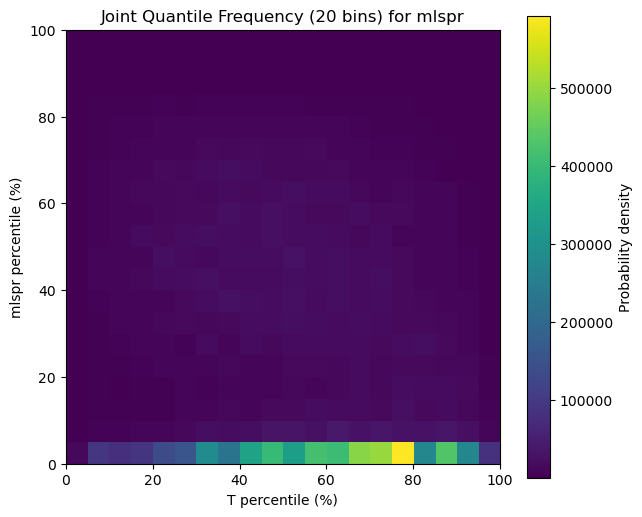

Processing variable: mper
Not enough data points for variable mper, skipping.
Processing variable: mror
Not enough data points for variable mror, skipping.
Processing variable: mslhf


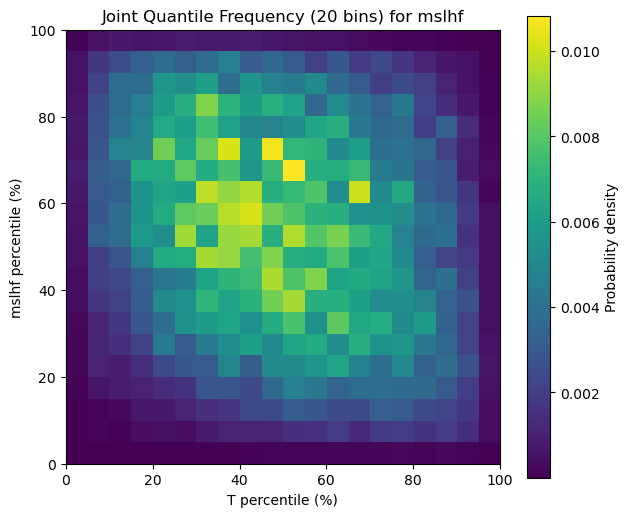

Processing variable: msnlwrf


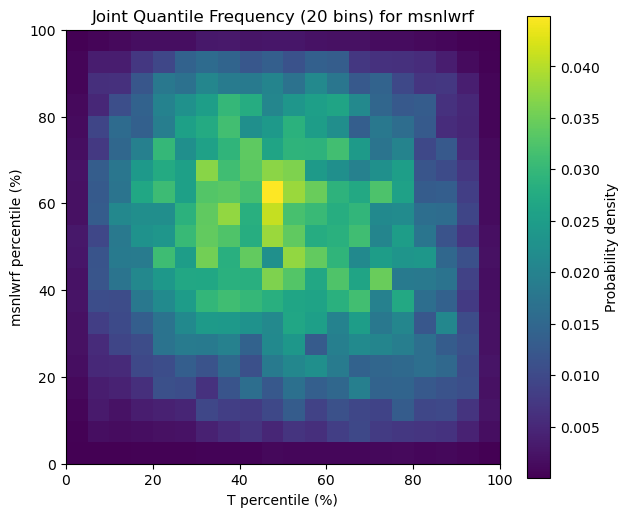

Processing variable: msnlwrfcs


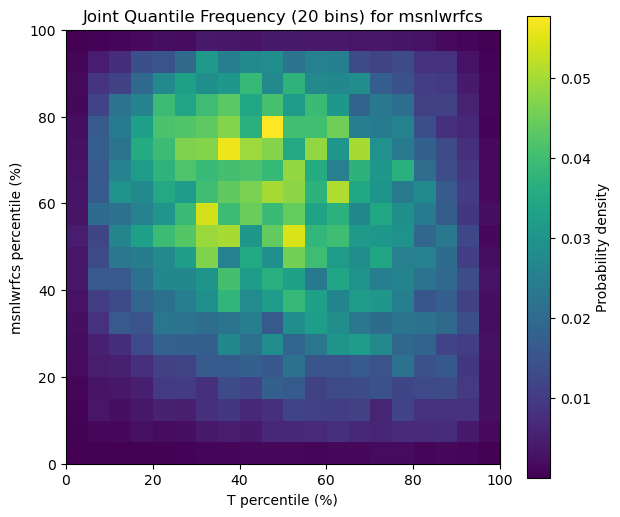

Processing variable: msnswrf


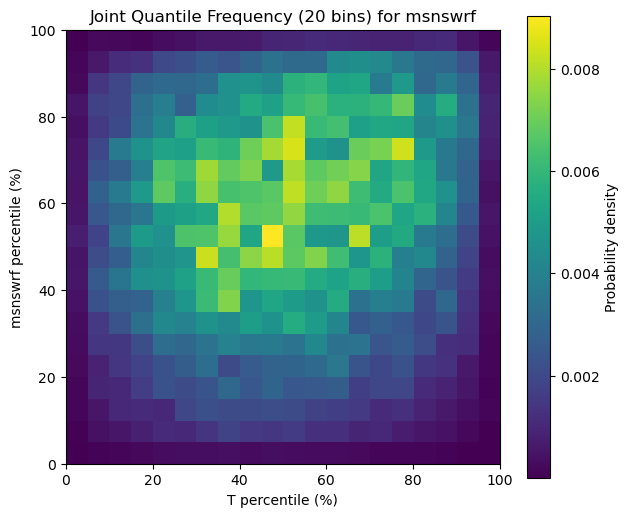

Processing variable: msnswrfcs
Not enough data points for variable msnswrfcs, skipping.
Processing variable: msror
Not enough data points for variable msror, skipping.
Processing variable: msshf


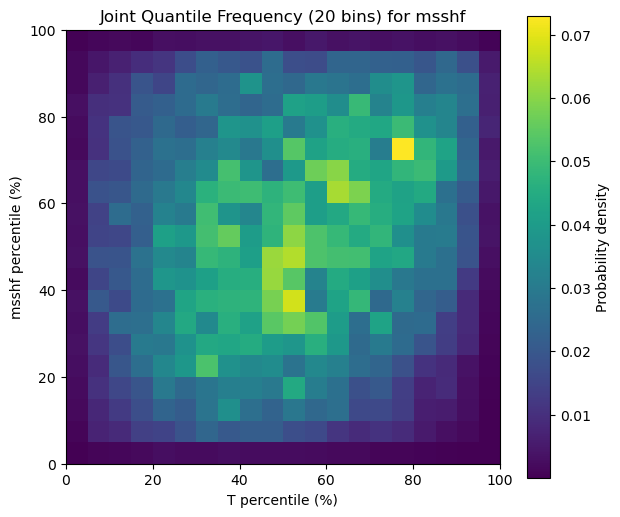

Processing variable: mtnlwrf


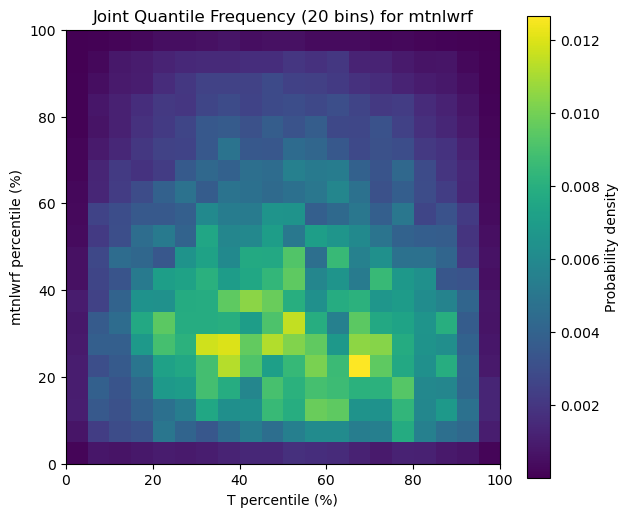

Processing variable: mtnlwrfcs


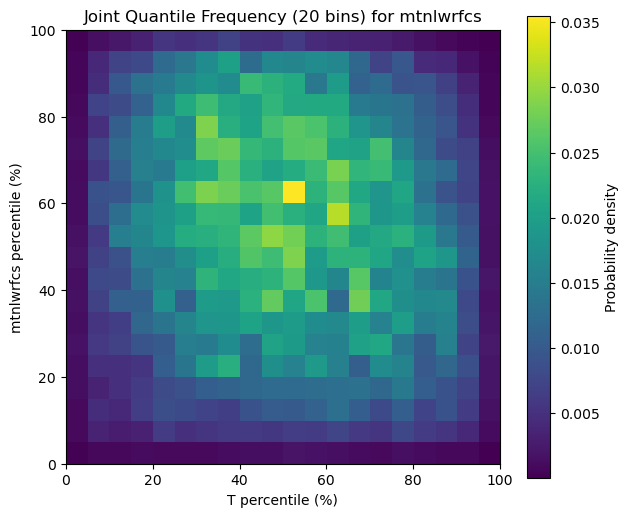

Processing variable: mtnswrf


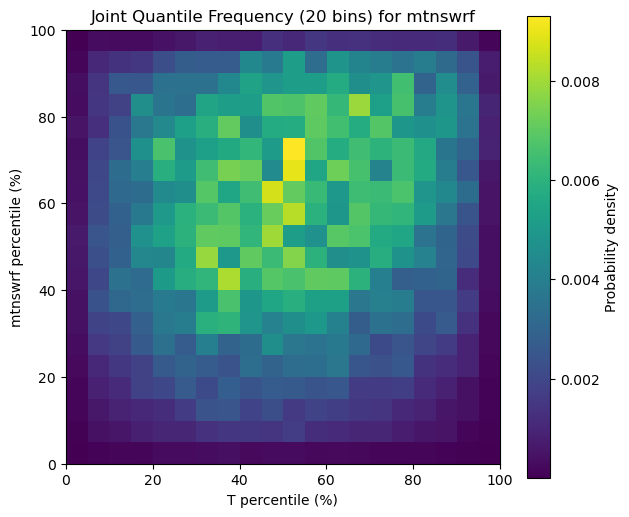

Processing variable: mtnswrfcs


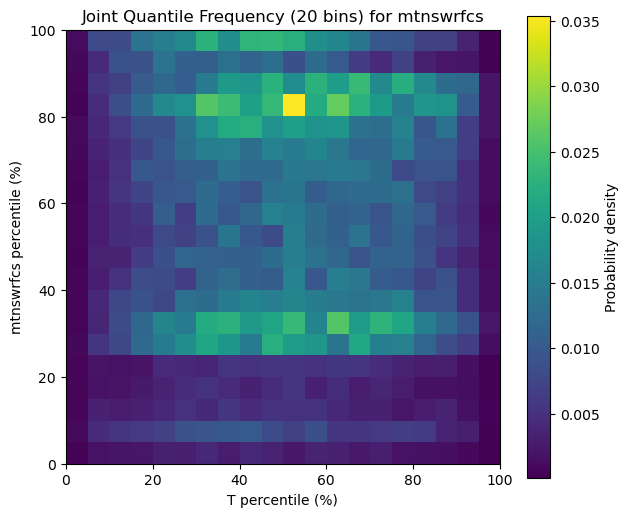

Processing variable: mtpr


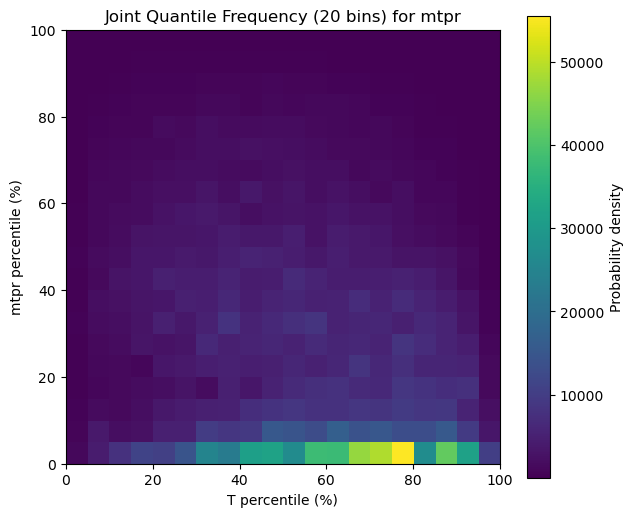

Processing variable: mvimd


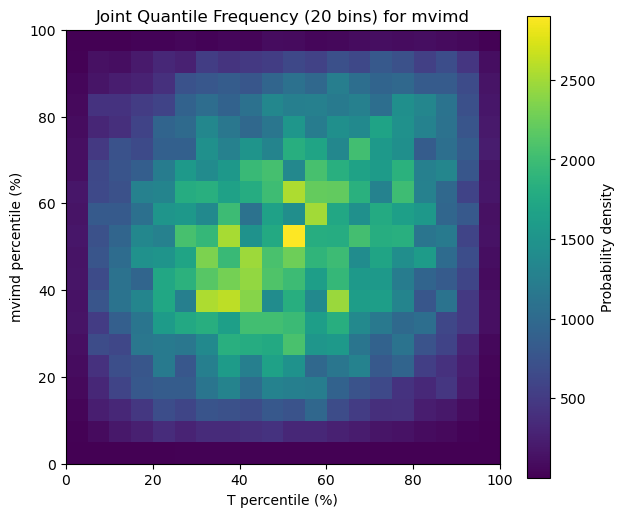

Processing variable: q2m


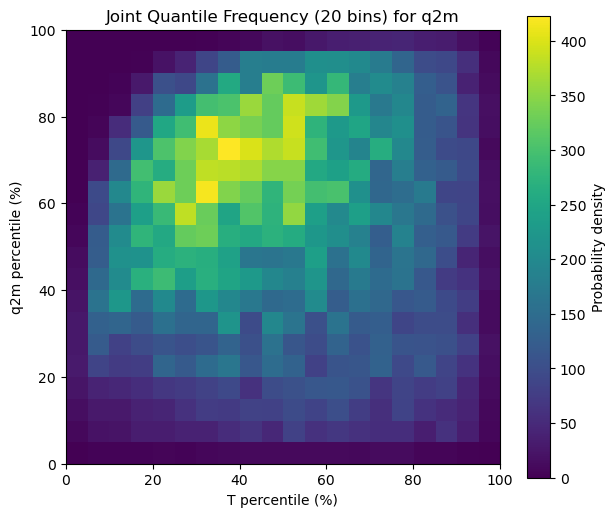

Processing variable: skt
Not enough data points for variable skt, skipping.
Processing variable: slt
Not enough data points for variable slt, skipping.
Processing variable: sp


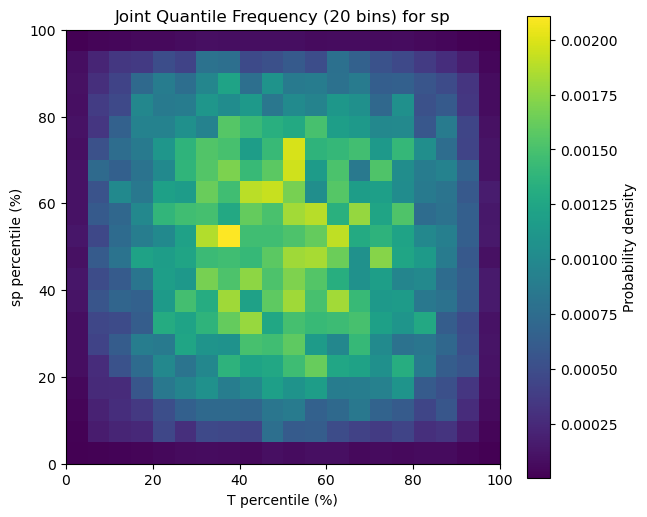

Processing variable: sst
Not enough data points for variable sst, skipping.
Processing variable: swvl1
Not enough data points for variable swvl1, skipping.
Processing variable: swvl2
Not enough data points for variable swvl2, skipping.
Processing variable: swvl3
Not enough data points for variable swvl3, skipping.
Processing variable: t2m


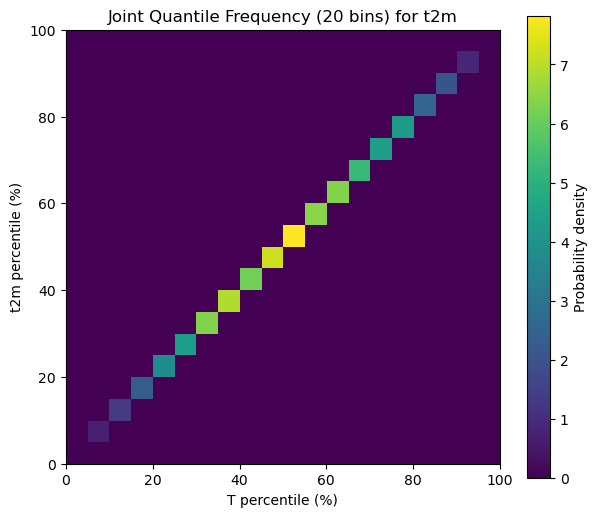

Processing variable: tcc


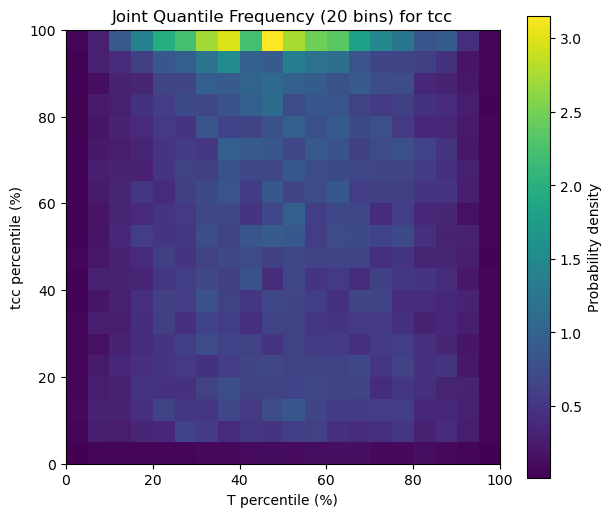

Processing variable: tciw


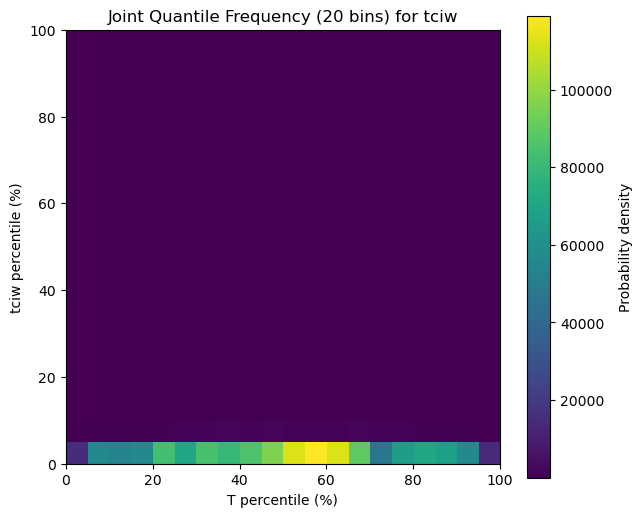

Processing variable: tclw


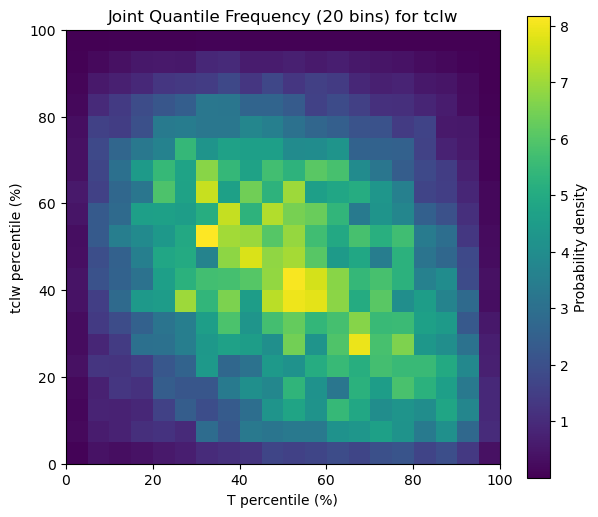

Processing variable: tcrw
Not enough data points for variable tcrw, skipping.
Processing variable: tcsw
Not enough data points for variable tcsw, skipping.
Processing variable: tcw
Not enough data points for variable tcw, skipping.
Processing variable: tcwv


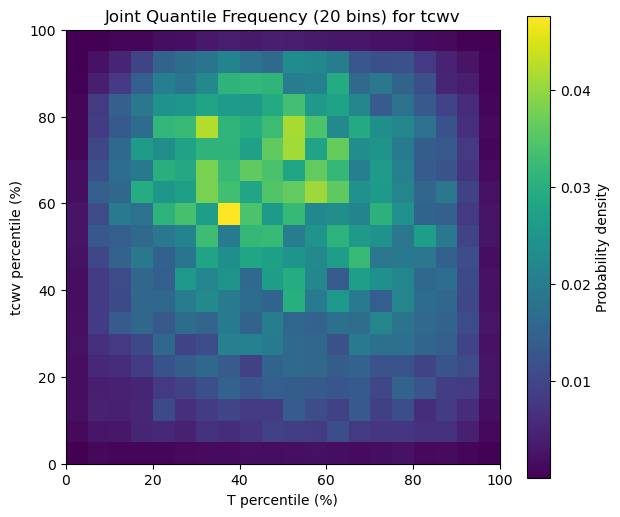

Processing variable: u10


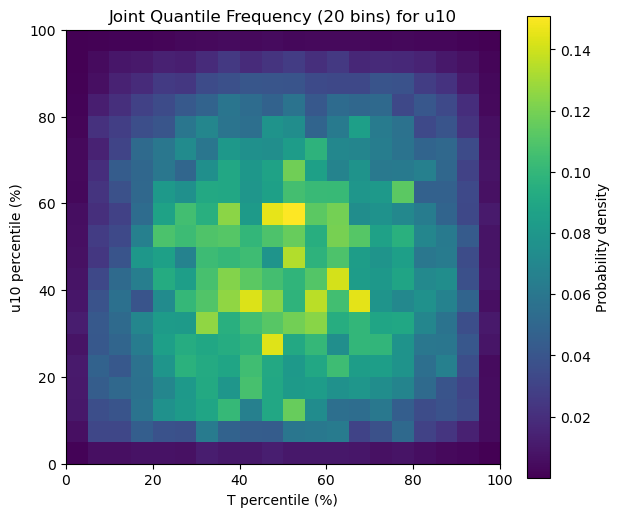

Processing variable: v10


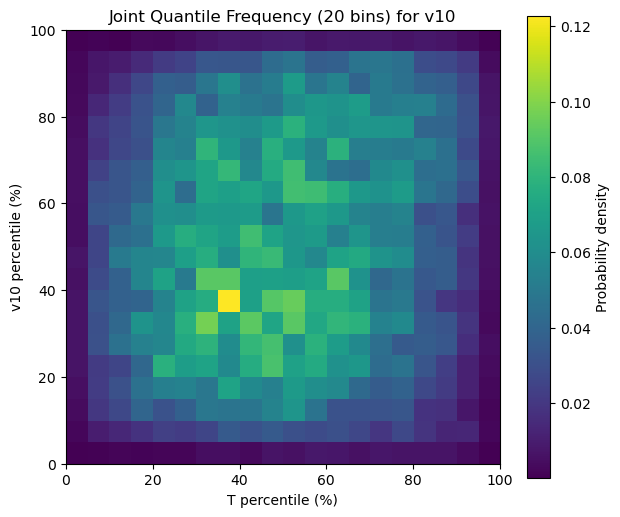

Processing variable: viiw


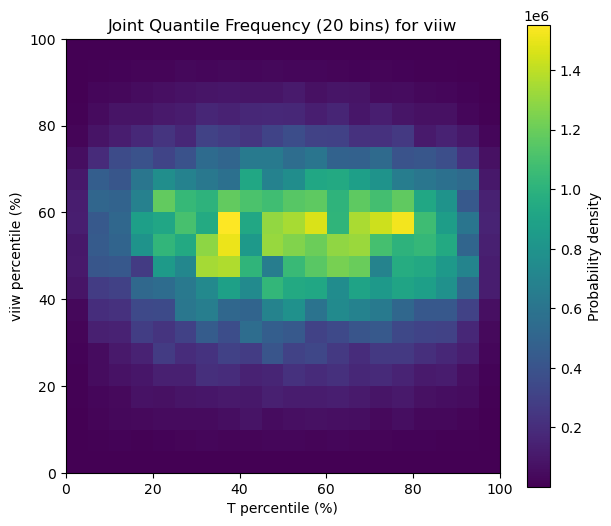

Processing variable: vilw


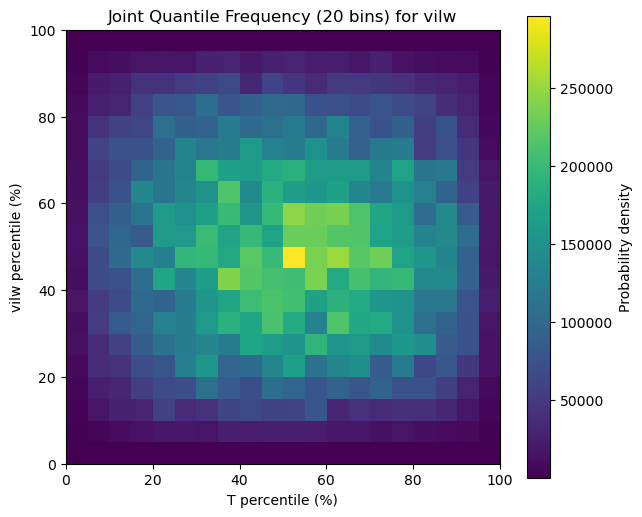

Processing variable: vimdf


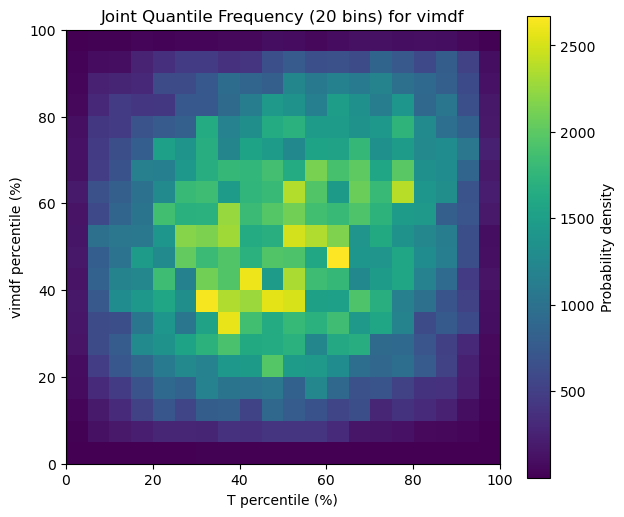

Processing variable: z_sfc


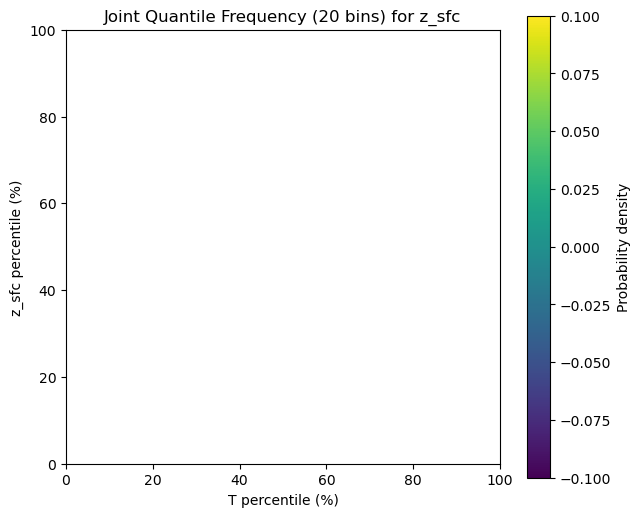

In [134]:
import matplotlib.pyplot as plt
lat, lon = 340, 800

# Flatten data
for var in analysis_vars:
    print(f"Processing variable: {var}")
    T_flat = d_daily.t2m.isel(lat=lat, lon=lon).values.flatten()
    y_flat = d_daily[var].isel(lat=lat, lon=lon).values.flatten()

    # Remove NaNs
    mask = ~np.isnan(T_flat) & ~np.isnan(y_flat)
    T_flat = T_flat[mask]
    y_flat = y_flat[mask]

    # Ensure there are enough data points
    if len(T_flat) < 100:
        print(f"Not enough data points for variable {var}, skipping.")
        continue
    # Define percentile edges for 20 bins (0%, 5%, ..., 100%)
    nBins = 20
    percentiles = np.linspace(0, 100, nBins + 1)
    T_edges = np.percentile(T_flat, percentiles)
    y_edges = np.percentile(y_flat, percentiles)

    # Compute 2D histogram (joint frequency in quantile bins)
    hist, _, _ = np.histogram2d(T_flat, y_flat, bins=[T_edges, y_edges], density=True)

    # Plot
    plt.figure(figsize=(7,6))
    plt.imshow(hist.T, origin='lower', aspect='equal',
            extent=[0,100,0,100],  # axes in percentiles
            cmap='viridis')
    plt.colorbar(label='Probability density')
    plt.xlabel('T percentile (%)')
    plt.ylabel(f'{var} percentile (%)')
    plt.title(f'Joint Quantile Frequency ({nBins} bins) for {var}')
    plt.show()

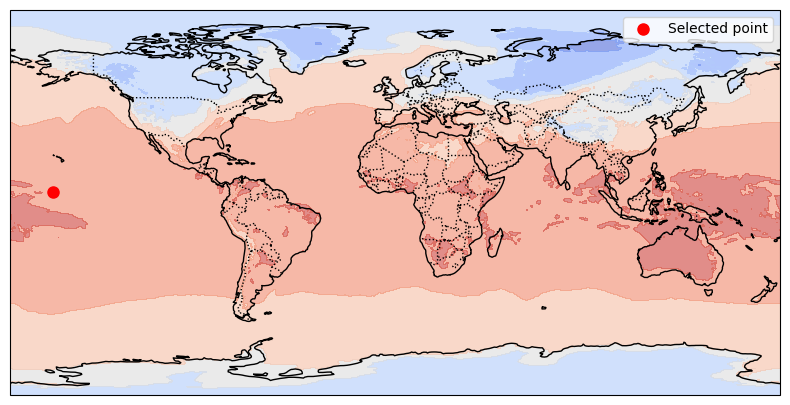

In [128]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Get the actual lat/lon values from your dataset
lat_value = d_daily.lat.isel(lat=340).values
lon_value = d_daily.lon.isel(lon=800).values 
lon_value = (lon_value + 180) % 360 - 180

# Create a map
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.contourf(d_daily.lon, d_daily.lat, d_daily.t2m.isel(time=0), 
             transform=ccrs.PlateCarree(), cmap='coolwarm', alpha=0.6)

# Plot the point
ax.plot(lon_value, lat_value, 'ro', markersize=8, label='Selected point')
plt.legend()
plt.show()

In [ ]:
# conver to -180, 180, 
lon_value = (lon_value + 180) % 360 - 180

np.float32(200.0)